# Model Evaluation
The following section uses the trained models to predict values for the NB / SWB samples. These will be stored in pandas dataframes and visualised using various tables and graphs

In [29]:
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from keras import backend as K
from time import time
#from collections import Counter
import matplotlib.pyplot as plt
#import os
#%matplotlib inline
#from sklearn.multiclass import OneVsOneClassifier
#from sklearn import svm, preprocessing
#from sklearn.metrics import classification_report, confusion_matrix  
#import pickle
import pandas as pd
from IPython.display import display 
from PIL import Image

In [38]:
#fullres3.to_csv('final_compared_results_SWB.csv', index=False)
fullres3 = pd.read_csv('final_compared_results_SWB.csv')
fullres2.read_csv('comparedresultsNB.csv')

## Generate Predictions

In [2]:
#dfrand.to_csv('randomisedSWBscores.csv',index=False)
#dfrand=pd.read_csv('randomisedSWBscores.csv')
#dfrand.to_csv('randomisedNBscores.csv',index=False)
dfrand=pd.read_csv('randomisedNBscores.csv')

In [3]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
batch_size = 1

shift=0.2
#featurewise_center=False, featurewise_std_normalization=False, rotation_range=90, width_shift_range=shift, height_shift_range=shiftzca_whitening=True, horizontal_flip=True, -- for data aug
#contrast_stretching=True, adaptive_equalization=True, histogram_equalization=True, rotation_range=90, width_shift_range=shift, height_shift_range=shift, zca_whitening=True, horizontal_flip=True,
train_generator = datagen.flow_from_dataframe(
                                              dataframe=dfrand, directory='D:\\Spectrograms\\NB\\', x_col="Spectrograms", y_col="MOS",
                                              target_size=(217,781), shuffle=True, batch_size=1, class_mode='other', 
                                              subset='training')
validation_generator = datagen.flow_from_dataframe(dataframe=dfrand, directory='D:\\Spectrograms\\NB\\', x_col="Spectrograms", y_col="MOS",
                                              target_size=(217,781), shuffle=True, batch_size=1, class_mode='other', 
                                              subset='validation')   

Found 57702 images.
Found 14425 images.


In [5]:
from keras.models import load_model


model=load_model('./models/vgg16_avg_NOdropoutFULL.h5')
#model.load_weights('./models/vgg16avgSWBBESTEVER.h5')
model.load_weights('./models/vgg16avg_NB_trained_WOdropoutBEST.h5')
filenames = validation_generator.filenames
nb_samples = len(filenames)
pred=model.predict_generator(validation_generator, steps=validation_generator.samples // batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
tfilenames = train_generator.filenames
df1=pd.DataFrame(tfilenames,columns=["filename"])
df1.to_csv('training_fnames.csv',index=False)

vfilenames = validation_generator.filenames
df2=pd.DataFrame(vfilenames,columns=["filename"])
df2.to_csv('validation_fnames.csv',index=False)

In [6]:
filenames=validation_generator.filenames
results=pd.DataFrame({'Degraded':filenames,'MOS_pred':pred[:,0]})
results.to_csv("results_NB.csv",index=False)
#results.to_csv("results_SWB.csv",index=False)

## Load and Prepare Results for Evaluation

In [8]:
#pesq=pd.read_csv('..\PESQ_results\PESQ_results_SWB.csv', dtype={'Degraded':str, 'MOS-LQO':np.float32})
pesq=pd.read_csv('..\PESQ_results\PESQ_results_NB.csv', dtype={'Degraded':str, 'MOS':np.str})
#pesq.drop('Column1', axis=1, inplace=True)
pesq.head()

,Reference,Degraded,Raw MOS,MOS
0,1028-20100710-hne_ar-01_delay_50_jitter_1_plr_1,1028-20100710-hne_ar-01_delay_50_jitter_1_plr...,3.562,3.638
1,1028-20100710-hne_ar-02_delay_50_jitter_1_plr_3,1028-20100710-hne_ar-02_delay_50_jitter_1_plr...,2.337,1.948
2,1028-20100710-hne_ar-03_delay_50_jitter_1_plr_5,1028-20100710-hne_ar-03_delay_50_jitter_1_plr...,3.181,3.092
3,1028-20100710-hne_ar-04_delay_50_jitter_5_plr_1,1028-20100710-hne_ar-04_delay_50_jitter_5_plr...,3.36,3.356
4,1028-20100710-hne_ar-05_delay_50_jitter_5_plr_3,1028-20100710-hne_ar-05_delay_50_jitter_5_plr...,4.156,4.299


In [9]:
#pesq.rename(columns={'degraded':'Degraded'}, inplace=True )
#pesq=pesq[['Degraded','MOS-LQO']]
pesq=pesq[['Degraded','MOS']]


In [10]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)


# simple example of trimming whitespace from data elements
#df = pd.DataFrame([['  a  ', 10], ['  c  ', 5]])
pesq = trim_all_columns(pesq)


In [19]:
#results=pd.read_csv('results_swb.csv', dtype={'Degraded':str, 'MOS_pred':np.float32})
#results=pd.read_csv('results_nb.csv', dtype={'Degraded':str, 'MOS_pred':np.float32})
results.rename(columns={'MOS_pred':'MOS_CNN'}, inplace=True)
results.head()

,Degraded,MOS_CNN
0,mcmurray02-20090312-joh_b0292_delay_300_jitter...,4.038594
1,LunaTick-20080326-cc_cc-18_delay_300_jitter_5_...,3.796870
2,neuralnet-20080702-jvy_b0360_delay_50_jitter_1...,3.175874
3,anonymous-20141225-jpm_a0261_delay_300_jitter_...,3.857872
4,anonymous-20100821-ril_b0238_delay_50_jitter_1...,3.954213


In [12]:
p563=pd.read_csv('../P563_results/P563_results_NB2.csv')
#p563=pd.read_csv('../P563_results/P563_results_SWB.csv')
p563.head()

,Degraded,MOS_P563
0,1028-20100710-hne_ar-01_delay_50_jitter_1_plr_...,3.573338
1,1028-20100710-hne_ar-02_delay_50_jitter_1_plr_...,3.625382
2,1028-20100710-hne_ar-03_delay_50_jitter_1_plr_...,4.546327
3,1028-20100710-hne_ar-04_delay_50_jitter_5_plr_...,3.998104
4,1028-20100710-hne_ar-05_delay_50_jitter_5_plr_...,4.792066


In [13]:
p563.Degraded=p563.Degraded.str[:-4]
results.Degraded=results.Degraded.str[:-4]

In [63]:
dfrand.rename(columns={'MOS':'MOS_polqa'}, inplace=True)
polqamos=dfrand['MOS_polqa']
polqamos=polqamos[:14425]
#polqamos=polqamos[:14421]
polqa_cnn=pd.concat([results, polqamos], axis=1)
polqa_cnn.shape
polqa_cnn.head()

,Degraded,MOS_CNN,MOS_polqa
0,mcmurray02-20090312-joh_b0292_delay_300_jitter...,4.038594,3.80
1,LunaTick-20080326-cc_cc-18_delay_300_jitter_5_...,3.796870,3.99
2,neuralnet-20080702-jvy_b0360_delay_50_jitter_1...,3.175874,3.32
3,anonymous-20141225-jpm_a0261_delay_300_jitter_...,3.857872,3.86
4,anonymous-20100821-ril_b0238_delay_50_jitter_1...,3.954213,4.50


In [21]:
new1=pd.merge(results,pesq, how='left',  on='Degraded')
new2=pd.merge(new1,p563,how='left', on='Degraded')
fullres=pd.merge(polqa_cnn,p563,how='left', on='Degraded')
fullres2=pd.merge(fullres,pesq,how='left', on='Degraded')
fullres2.rename(columns={'MOS':'MOS_PESQ'}, inplace=True)
fullres2.head()

#new1=pd.merge(results,pesq, how='left',  on='Degraded')
#new2=pd.merge(new1,p563,how='left', on='Degraded')
#fullres=pd.merge(polqa_cnn,p563,how='left', on='Degraded')
#fullres3=pd.merge(fullres,pesq,how='left', on='Degraded')
#fullres3.rename(columns={'MOS-LQO':'MOS_PESQ'}, inplace=True)
#fullres3.head()

,Degraded,MOS_CNN,MOS_polqa,MOS_P563,MOS_PESQ
0,mcmurray02-20090312-joh_b0292_delay_300_jitter...,4.038594,3.80,3.203026,3.382
1,LunaTick-20080326-cc_cc-18_delay_300_jitter_5_...,3.796870,3.99,4.003209,3.349
2,neuralnet-20080702-jvy_b0360_delay_50_jitter_1...,3.175874,3.32,4.437272,2.711
3,anonymous-20141225-jpm_a0261_delay_300_jitter_...,3.857872,3.86,3.827099,3.415
4,anonymous-20100821-ril_b0238_delay_50_jitter_1...,3.954213,4.50,5.000000,3.944


In [64]:
fullres2.fillna(0,inplace=True)
fullres3.fillna(0,inplace=True)
fullres2.head()

,Degraded,MOS_CNN,MOS_polqa,MOS_P563,MOS_PESQ,CNNerr,PESQerr,P563err,CNNacc,PESQacc,P563acc
0,mcmurray02-20090312-joh_b0292_delay_300_jitter...,4.038594,3.80,3.203026,3.382,0.238594,0.418,0.596974,96.731586,94.273973,91.822274
1,LunaTick-20080326-cc_cc-18_delay_300_jitter_5_...,3.796870,3.99,4.003209,3.349,0.193130,0.641,0.013209,97.421498,91.441923,99.823645
2,neuralnet-20080702-jvy_b0360_delay_50_jitter_1...,3.175874,3.32,4.437272,2.711,0.144126,0.609,1.117272,97.886712,91.070381,83.617713
3,anonymous-20141225-jpm_a0261_delay_300_jitter_...,3.857872,3.86,3.827099,3.415,0.002128,0.445,0.032901,99.971094,93.953804,99.552976
4,anonymous-20100821-ril_b0238_delay_50_jitter_1...,3.954213,4.50,5.000000,3.944,0.545787,0.556,0.500000,93.177661,93.050000,93.750000


In [22]:

fullres2['MOS_PESQ'] = fullres2['MOS_PESQ'].convert_objects(convert_numeric=True)
fullres2['MOS_CNN'] = fullres2['MOS_CNN'].convert_objects(convert_numeric=True)
fullres2['MOS_P563'] = fullres2['MOS_P563'].convert_objects(convert_numeric=True)

#fullres3['MOS_PESQ'] = fullres3['MOS_PESQ'].convert_objects(convert_numeric=True)
#fullres3['MOS_CNN'] = fullres3['MOS_CNN'].convert_objects(convert_numeric=True)
#fullres3['MOS_P563'] = fullres3['MOS_P563'].convert_objects(convert_numeric=True)

C:\Users\spike\Anaconda3\envs\tf_gpu2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\spike\Anaconda3\envs\tf_gpu2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\spike\Anaconda3\envs\tf_gpu2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_ti

In [23]:
def relacc(y_true, y_pred, mode): 
    if (mode == 'swb'):
        scr_range=4.75-1
    elif (mode == 'nb'):
        scr_range=4.5-1
        
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100-np.mean((np.abs((y_true - y_pred) /(scr_range + y_true)))) * 100

In [24]:
fullres2['CNNerr']=np.abs(fullres2['MOS_CNN']-fullres2['MOS_polqa'])
fullres2['PESQerr']=np.abs(fullres2['MOS_PESQ']-fullres2['MOS_polqa'])
fullres2['P563err']=np.abs(fullres2['MOS_P563']-fullres2['MOS_polqa'])
#fullres2=fullres2['mean-act']=np.abs(np.mean(fullres2['MOS_polqa'])-fullres2['MOS_polqa'])
#fullres2['relerr']=fullres2['CNNerr']/fullres2['mean-act']
#fullres2=fullres2.drop('relerr', axis=1)
#ullres2=fullres2.drop('mean-act', axis=1)
#fullres2
fullres2['CNNacc']=(100-(np.abs(fullres2['MOS_polqa']-fullres2['MOS_CNN'])/(3.5+fullres2['MOS_polqa'])*100))
fullres2['PESQacc']=(100-(np.abs(fullres2['MOS_polqa']-fullres2['MOS_PESQ'])/(3.5+fullres2['MOS_polqa'])*100))
fullres2['P563acc']=(100-(np.abs(fullres2['MOS_polqa']-fullres2['MOS_P563'])/(3.5+fullres2['MOS_polqa'])*100))
fullres2.head()
#Accuracy = (Actual value - (Actual value - Measurement)) / Actual value = (32-(32 - 31)) / 32 = 0.968
#3.82 - (3.82-3.8)/3.82
#3.8 - (3.8-3.82)/3.8


,Degraded,MOS_CNN,MOS_polqa,MOS_P563,MOS_PESQ,CNNerr,PESQerr,P563err,CNNacc,PESQacc,P563acc
0,mcmurray02-20090312-joh_b0292_delay_300_jitter...,4.038594,3.80,3.203026,3.382,0.238594,0.418,0.596974,96.731586,94.273973,91.822274
1,LunaTick-20080326-cc_cc-18_delay_300_jitter_5_...,3.796870,3.99,4.003209,3.349,0.193130,0.641,0.013209,97.421498,91.441923,99.823645
2,neuralnet-20080702-jvy_b0360_delay_50_jitter_1...,3.175874,3.32,4.437272,2.711,0.144126,0.609,1.117272,97.886712,91.070381,83.617713
3,anonymous-20141225-jpm_a0261_delay_300_jitter_...,3.857872,3.86,3.827099,3.415,0.002128,0.445,0.032901,99.971094,93.953804,99.552976
4,anonymous-20100821-ril_b0238_delay_50_jitter_1...,3.954213,4.50,5.000000,3.944,0.545787,0.556,0.500000,93.177661,93.050000,93.750000


In [733]:
fullres3['CNNerr']=np.abs(fullres3['MOS_CNN']-fullres3['MOS_polqa'])
fullres3['PESQerr']=np.abs(fullres3['MOS_PESQ']-fullres3['MOS_polqa'])
fullres3['P563err']=np.abs(fullres3['MOS_P563']-fullres3['MOS_polqa'])
#fullres2=fullres2['mean-act']=np.abs(np.mean(fullres2['MOS_polqa'])-fullres2['MOS_polqa'])
#fullres2['relerr']=fullres2['CNNerr']/fullres2['mean-act']
#fullres2=fullres2.drop('relerr', axis=1)
#ullres2=fullres2.drop('mean-act', axis=1)
#fullres2
fullres3['CNNacc']=(100-(np.abs(fullres3['MOS_polqa']-fullres3['MOS_CNN'])/(3.75+fullres3['MOS_polqa'])*100))
fullres3['PESQacc']=(100-(np.abs(fullres3['MOS_polqa']-fullres3['MOS_PESQ'])/(3.75+fullres3['MOS_polqa'])*100))
fullres3['P563acc']=(100-(np.abs(fullres3['MOS_polqa']-fullres3['MOS_P563'])/(3.75+fullres3['MOS_polqa'])*100))
fullres3.head()

,Degraded,MOS_CNN,MOS_polqa,MOS_P563,MOS_PESQ,CNNerr,PESQerr,P563err,CNNacc,PESQacc,P563acc
0,frankster-20170507-anw_en-0517_plr5_opus,0.993981,3.88,1.0,3.734,2.886019,0.146,2.88,62.175370,98.086500,62.254260
1,wicke-20090314-jtl_rb-18_plr5_opus,3.910668,2.93,0.0,3.813,0.980668,0.883,2.93,85.319343,86.781438,56.137725
2,Robin-20071226-fhc_b0010_plr5_evs,4.504822,4.05,1.0,3.536,0.454822,0.514,3.05,94.168945,93.410257,60.897436
3,Q-20150606-gth_a0298_plr5_evs,0.958697,4.15,1.0,3.997,3.191303,0.153,3.15,59.603761,98.063291,60.126582
4,taslack-20090113-vno_ar-23_plr1_opus,3.940373,4.18,0.0,4.131,0.239627,0.049,4.18,96.978218,99.382094,47.288777


## Comparison to ITU-T Standards 

<Figure size 14400x7200 with 0 Axes>

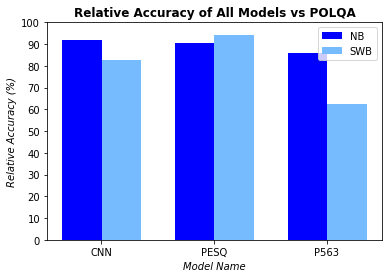

In [41]:

plt.figure(figsize=(200,100))
ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 1.0
 
rects1 = plt.bar(index, dfacc['Relative Accuracy (NB)'], bar_width,
        alpha=opacity,
color='b',
label='NB')
 
rects2 = plt.bar(index + bar_width, dfacc['Relative Accuracy (SWB)'], bar_width,
alpha=opacity,
color='xkcd:sky blue',
label='SWB')
 
plt.xlabel('Model Name',style="italic")
plt.ylabel('Relative Accuracy (%)', style="italic")
plt.title('Relative Accuracy of All Models vs POLQA', fontweight="bold")
plt.xticks(index + 0.17, ('CNN', 'PESQ', 'P563'))
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.legend()
plt.savefig("modelperformance.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')
plt.show()

In [432]:
!pip install seaborn

In [35]:
P563_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_P563'],'nb')
PESQ_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_PESQ'], 'nb')
CNN_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_CNN'], 'nb')

print(CNN_mean_accnb)
print(PESQ_mean_accnb)
print(P563_mean_accnb)

91.93130354250775
90.69743629234893
86.09168470730849


In [39]:
P563_mean_accswb=relacc(fullres3['MOS_polqa'],fullres3['MOS_P563'],'swb')
PESQ_mean_accswb=relacc(fullres3['MOS_polqa'],fullres3['MOS_PESQ'], 'swb')
CNN_mean_accswb=relacc(fullres3['MOS_polqa'],fullres3['MOS_CNN'], 'swb')

print(CNN_mean_accswb)
print(PESQ_mean_accswb)
print(P563_mean_accswb)


82.4956277846718
94.21713580799661
62.35510537634538


In [40]:
acc={'Method':['CNN','PESQ', 'P563'], 
      'Relative Accuracy (NB)':[CNN_mean_accnb, PESQ_mean_accnb, P563_mean_accnb],
      'Relative Accuracy (SWB)':[CNN_mean_accswb, PESQ_mean_accswb, P563_mean_accswb]}
dfacc= pd.DataFrame(data=acc)
dfacc

,Method,Relative Accuracy (NB),Relative Accuracy (SWB)
0,CNN,91.931304,82.495628
1,PESQ,90.697436,94.217136
2,P563,86.091685,62.355105


# NB - Impact of Impairments on MOS and Effects of Quality on Predictions

In [77]:
dfworst=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_10_plr_5")]
dfmed=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_5_plr_3")]
dfbest=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_1_plr_1")]
print(dfworst["MOS_polqa"].mean())
print(dfmed["MOS_polqa"].mean())
print(dfbest["MOS_polqa"].mean())
print(dfworst["MOS_CNN"].mean())
print(dfmed["MOS_CNN"].mean())
print(dfbest["MOS_CNN"].mean())

2.98484375
3.719758812615956
4.010298804780876
3.5286167
3.5291882
3.5242088


## Impact of Impairments on MOS and Effects of Quality on Predictions

In [43]:
dfopusswb=fullres3[fullres3['Degraded'].str.contains("opus")]
dfevsswb=fullres3[fullres3['Degraded'].str.contains("evs")]
dfplr5swb=fullres3[fullres3['Degraded'].str.contains("plr5")]
dfplr3swb=fullres3[fullres3['Degraded'].str.contains("plr3")]
dfplr1swb=fullres3[fullres3['Degraded'].str.contains("plr1")]
print(relacc(dfopusswb['MOS_polqa'],dfopusswb['MOS_CNN'],'swb'))
print(relacc(dfevsswb['MOS_polqa'],dfevsswb['MOS_CNN'],'swb'))
print('CNN EVS: '+str(np.mean(dfevsswb['MOS_CNN'])))
print('POLQA EVS: '+str(np.mean(dfevsswb['MOS_polqa'])))
print('CNN OPUS: '+str(np.mean(dfopusswb['MOS_CNN'])))
print('POLQA OPUS: '+str(np.mean(dfopusswb['MOS_polqa'])))
print('CNN PLR5: '+str(np.mean(dfplr5swb['MOS_CNN'])))
print('POLQA PLR5: '+str(np.mean(dfplr5swb['MOS_polqa'])))
print('CNN PLR3: '+str(np.mean(dfplr3swb['MOS_CNN'])))
print('POLQA PLR3: '+str(np.mean(dfplr3swb['MOS_polqa'])))
print('CNN PLR1: '+str(np.mean(dfplr1swb['MOS_CNN'])))
print('POLQA PLR1: '+str(np.mean(dfplr1swb['MOS_polqa'])))



82.80389610806648
82.18671750308596
CNN EVS: 3.5164520274468973
POLQA EVS: 3.4495585172844647
CNN OPUS: 3.545272330935162
POLQA OPUS: 3.5314186755333887
CNN PLR5: 3.5211465340206827
POLQA PLR5: 3.3532078593588417
CNN PLR3: 3.5498488117460645
POLQA PLR3: 3.4333222866611437
CNN PLR1: 3.521514519396805
POLQA PLR1: 3.68812736443884


In [44]:
CNNacc_swb1=relacc(dfplr1swb['MOS_polqa'],dfplr1swb['MOS_CNN'],'swb')
CNNacc_swb3=relacc(dfplr3swb['MOS_polqa'],dfplr3swb['MOS_CNN'],'swb')
CNNacc_swb5=relacc(dfplr5swb['MOS_polqa'],dfplr5swb['MOS_CNN'],'swb')


In [45]:
CNNacc_nb1=relacc(dfbest['MOS_polqa'],dfbest['MOS_CNN'],'nb')
CNNacc_nb3=relacc(dfmed['MOS_polqa'],dfmed['MOS_CNN'],'nb')
CNNacc_nb5=relacc(dfworst['MOS_polqa'],dfworst['MOS_CNN'],'nb')


In [65]:
dfavgs

,Condition,Mean_MOS_POLQA,Mean_MOS_CNN
0,opus,3.567424,3.531286
1,evs,3.488352,3.531933
2,plr5,3.353662,3.533535
3,plr3,3.522412,3.530429
4,plr1,3.710086,3.530851
5,d50,3.530383,3.531054
6,d100,3.521334,3.529860
7,d300,3.531990,3.533940
8,j1,3.431832,3.528817
9,j5,3.718234,3.537144


In [47]:
condacc={'Condition':['Best','Medium', 'Worst'], 
         'Mean MOS (NB)':[np.mean(dfbest['MOS_polqa']),np.mean(dfmed['MOS_polqa']),np.mean(dfworst['MOS_polqa'])],
         'Mean Predicted MOS (NB)':[np.mean(dfbest['MOS_CNN']),np.mean(dfmed['MOS_CNN']), np.mean(dfworst['MOS_CNN'])],
         'CNN Accuracy (NB)':[CNNacc_nb1, CNNacc_nb3, CNNacc_nb5],
         'Mean MOS (SWB)':[np.mean(dfplr1swb['MOS_polqa']),np.mean(dfplr3swb['MOS_polqa']),np.mean(dfplr5swb['MOS_polqa'])],
         'Average Predicted MOS (SWB)':[np.mean(dfplr1swb['MOS_CNN']),np.mean(dfplr3swb['MOS_CNN']),np.mean(dfplr5swb['MOS_CNN'])],
         'CNN Accuracy (SWB)':[CNNacc_swb1, CNNacc_swb3, CNNacc_swb5]}
dfcondacc= pd.DataFrame(data=condacc)
dfcondacc

,Condition,Mean MOS (NB),Mean Predicted MOS (NB),CNN Accuracy (NB),Mean MOS (SWB),Average Predicted MOS (SWB),CNN Accuracy (SWB)
0,Best,4.010299,3.524209,91.711071,3.688127,3.521515,82.421766
1,Medium,3.719759,3.529188,92.996120,3.433322,3.549849,82.578377
2,Worst,2.984844,3.528617,89.440628,3.353208,3.521147,82.485685


In [48]:
condswb={'Condition':['Opus','EVS', 'PLR 1','PLR3','PLR5'], 
         'Mean MOS (SWB)':[np.mean(dfopusswb['MOS_polqa']),np.mean(dfevsswb['MOS_polqa']),np.mean(dfplr1swb['MOS_polqa']),np.mean(dfplr3swb['MOS_polqa']),np.mean(dfplr5swb['MOS_polqa'])],
         'Average Predicted MOS (SWB)':[np.mean(dfopusswb['MOS_CNN']),np.mean(dfevsswb['MOS_CNN']),np.mean(dfplr1swb['MOS_CNN']),np.mean(dfplr3swb['MOS_CNN']),np.mean(dfplr5swb['MOS_CNN'])],
         }
dfcondswb= pd.DataFrame(data=condswb)
dfcondswb

,Condition,Mean MOS (SWB),Average Predicted MOS (SWB)
0,Opus,3.531419,3.545272
1,EVS,3.449559,3.516452
2,PLR 1,3.688127,3.521515
3,PLR3,3.433322,3.549849
4,PLR5,3.353208,3.521147


In [68]:
dflownb = fullres2.loc[fullres2['MOS_polqa']<=2.75]
dfhighnb = fullres2.loc[fullres2['MOS_polqa']>=2.75]
dflowswb = fullres3.loc[fullres3['MOS_polqa']<=2.875]
dfhighswb = fullres3.loc[fullres3['MOS_polqa']>=2.875]

In [69]:
qualacc={'Condition':['Low Quality (MOS <2.75 or 2.875) ','High Quality MOS > 2.75 or 2.875' , ], 
         'CNN Accuracy (NB)':[relacc(dflownb['MOS_polqa'],dflownb['MOS_CNN'],'nb'),relacc(dfhighnb['MOS_polqa'],dfhighnb['MOS_CNN'],'nb')],
         'CNN Accuracy (SWB)':[relacc(dflowswb['MOS_polqa'],dflowswb['MOS_CNN'],'swb'),relacc(dfhighswb['MOS_polqa'],dfhighswb['MOS_CNN'],'swb')]}
dfqualacc= pd.DataFrame(data=qualacc)
dfqualacc

,Condition,CNN Accuracy (NB),CNN Accuracy (SWB)
0,Low Quality (MOS <2.75 or 2.875),80.717582,59.288092
1,High Quality MOS > 2.75 or 2.875,92.764367,88.748996


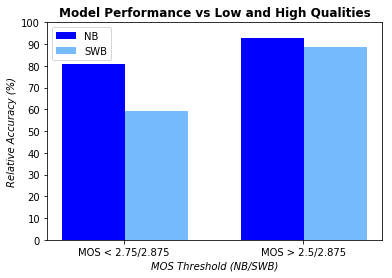

In [70]:

fig,ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35
opacity = 1.0
 
rects1 = plt.bar(index, dfqualacc['CNN Accuracy (NB)'], bar_width,
        alpha=opacity,
color='b',
label='NB')
 
rects2 = plt.bar(index + bar_width, dfqualacc['CNN Accuracy (SWB)'], bar_width,
alpha=opacity,
color='xkcd:sky blue',
label='SWB')
 
plt.xlabel('MOS Threshold (NB/SWB)', style='italic')
plt.ylabel('Relative Accuracy (%)', style='italic')
plt.title('Model Performance vs Low and High Qualities', fontweight="bold")
plt.xticks(index + 0.17, ('MOS < 2.75/2.875', 'MOS > 2.5/2.875'))
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.legend()
plt.savefig("Qualityvsmodelperf.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')
plt.show()

In [50]:
tc1=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_1_plr_1")]
tc2=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_1_plr_3")]
tc3=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_1_plr_5")]
tc4=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_5_plr_1")]
tc5=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_5_plr_3")]
tc6=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_5_plr_5")]
tc7=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_10_plr_1")]
tc8=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_10_plr_3")]
tc9=fullres2[fullres2['Degraded'].str.contains("delay_50_jitter_10_plr_1")]
tc10=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_1_plr_1")]
tc11=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_1_plr_3")]
tc12=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_1_plr_5")]
tc13=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_5_plr_1")]
tc14=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_5_plr_3")]
tc15=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_5_plr_5")]
tc16=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_10_plr_1")]
tc17=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_10_plr_3")]
tc18=fullres2[fullres2['Degraded'].str.contains("delay_100_jitter_10_plr_5")]
tc19=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_1_plr_1")]
tc20=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_1_plr_3")]
tc21=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_1_plr_5")]
tc22=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_5_plr_1")]
tc23=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_5_plr_3")]
tc24=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_5_plr_5")]
tc25=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_10_plr_1")]
tc26=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_10_plr_3")]
tc27=fullres2[fullres2['Degraded'].str.contains("delay_300_jitter_10_plr_5")]





#(dfopus[['MOS_CNN','MOS_polqa']].astype(float)).plot(kind='bar', subplots=False)


In [76]:
dfopus.rename(columns={"MOS_polqa": "MOS_polqa_opus", "MOS_CNN": "MOS_CNN_opus"}, inplace=True)
dfevs.rename(columns={"MOS_polqa": "MOS_polqa_evs", "MOS_CNN": "MOS_CNN_evs"}, inplace=True)
opscr=dfopus[['MOS_polqa_opus','MOS_CNN_opus']]
evsscr=dfevs[['MOS_polqa_evs','MOS_CNN_evs']]
dfcodecs=pd.concat([evsscr,opscr], axis=1)
#dfcodecs.rename(columns({'MOS_polqa_evs':np.float32,'MOS_CNN_evs':np.float32,'MOS_polqa_opus':np.float32,'MOS_CNN_opus':np.float32})
#(dfcodecs[['MOS_polqa_opus','MOS_polqa_evs']].astype(float)).plot(kind='hi', subplots=True)
#dfcodecs
tcs=np.arange(1,27,1)
tc={'Condition':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], 
      'Mean_MOS_POLQA':[tc1["MOS_polqa"].mean(),
                        tc2["MOS_polqa"].mean(), 
                        tc3['MOS_polqa'].mean(),
                        tc4['MOS_polqa'].mean(),
                        tc5['MOS_polqa'].mean(),
                        tc6['MOS_polqa'].mean(),
                        tc7['MOS_polqa'].mean(),
                        tc8['MOS_polqa'].mean(),
                        tc9['MOS_polqa'].mean(), 
                        tc10['MOS_polqa'].mean(),
                        tc11['MOS_polqa'].mean(),
                        tc12["MOS_polqa"].mean(),
                        tc13["MOS_polqa"].mean(), 
                        tc14['MOS_polqa'].mean(),
                        tc15['MOS_polqa'].mean(),
                        tc16['MOS_polqa'].mean(),
                        tc17['MOS_polqa'].mean(),
                        tc18['MOS_polqa'].mean(),
                        tc19['MOS_polqa'].mean(),
                        tc20['MOS_polqa'].mean(), 
                        tc21['MOS_polqa'].mean(),
                        tc22['MOS_polqa'].mean(),
                        tc23['MOS_polqa'].mean(),
                        tc24['MOS_polqa'].mean(),
                        tc25['MOS_polqa'].mean(),
                        tc26['MOS_polqa'].mean(), 
                        tc27['MOS_polqa'].mean()],
     'Mean_MOS_CNN':[tc1["MOS_CNN"].mean(),
                        tc2["MOS_CNN"].mean(), 
                        tc3['MOS_CNN'].mean(),
                        tc4['MOS_CNN'].mean(),
                        tc5['MOS_CNN'].mean(),
                        tc6['MOS_CNN'].mean(),
                        tc7['MOS_CNN'].mean(),
                        tc8['MOS_CNN'].mean(),
                        tc9['MOS_CNN'].mean(), 
                        tc10['MOS_CNN'].mean(),
                        tc11['MOS_CNN'].mean(),
                        tc12["MOS_CNN"].mean(),
                        tc13["MOS_CNN"].mean(), 
                        tc14['MOS_CNN'].mean(),
                        tc15['MOS_CNN'].mean(),
                        tc16['MOS_CNN'].mean(),
                        tc17['MOS_CNN'].mean(),
                        tc18['MOS_CNN'].mean(),
                        tc19['MOS_CNN'].mean(),
                        tc20['MOS_CNN'].mean(), 
                        tc21['MOS_CNN'].mean(),
                        tc22['MOS_CNN'].mean(),
                        tc23['MOS_CNN'].mean(),
                        tc24['MOS_CNN'].mean(),
                        tc25['MOS_CNN'].mean(),
                        tc26['MOS_CNN'].mean(), 
                        tc27['MOS_CNN'].mean()],
        'Mean_MOS_PESQ':[tc1["MOS_PESQ"].mean(),
                        tc2["MOS_PESQ"].mean(), 
                        tc3['MOS_PESQ'].mean(),
                        tc4['MOS_PESQ'].mean(),
                        tc5['MOS_PESQ'].mean(),
                        tc6['MOS_PESQ'].mean(),
                        tc7['MOS_PESQ'].mean(),
                        tc8['MOS_PESQ'].mean(),
                        tc9['MOS_PESQ'].mean(), 
                        tc10['MOS_PESQ'].mean(),
                        tc11['MOS_PESQ'].mean(),
                        tc12["MOS_PESQ"].mean(),
                        tc13["MOS_PESQ"].mean(), 
                        tc14['MOS_PESQ'].mean(),
                        tc15['MOS_PESQ'].mean(),
                        tc16['MOS_PESQ'].mean(),
                        tc17['MOS_PESQ'].mean(),
                        tc18['MOS_PESQ'].mean(),
                        tc19['MOS_PESQ'].mean(),
                        tc20['MOS_PESQ'].mean(), 
                        tc21['MOS_PESQ'].mean(),
                        tc22['MOS_PESQ'].mean(),
                        tc23['MOS_PESQ'].mean(),
                        tc24['MOS_PESQ'].mean(),
                        tc25['MOS_PESQ'].mean(),
                        tc26['MOS_PESQ'].mean(), 
                        tc27['MOS_PESQ'].mean()],
       'Mean_MOS_P563':[tc1["MOS_P563"].mean(),
                        tc2["MOS_P563"].mean(), 
                        tc3['MOS_P563'].mean(),
                        tc4['MOS_P563'].mean(),
                        tc5['MOS_P563'].mean(),
                        tc6['MOS_P563'].mean(),
                        tc7['MOS_P563'].mean(),
                        tc8['MOS_P563'].mean(),
                        tc9['MOS_P563'].mean(), 
                        tc10['MOS_P563'].mean(),
                        tc11['MOS_P563'].mean(),
                        tc12["MOS_P563"].mean(),
                        tc13["MOS_P563"].mean(), 
                        tc14['MOS_P563'].mean(),
                        tc15['MOS_P563'].mean(),
                        tc16['MOS_P563'].mean(),
                        tc17['MOS_P563'].mean(),
                        tc18['MOS_P563'].mean(),
                        tc19['MOS_P563'].mean(),
                        tc20['MOS_P563'].mean(), 
                        tc21['MOS_P563'].mean(),
                        tc22['MOS_P563'].mean(),
                        tc23['MOS_P563'].mean(),
                        tc24['MOS_P563'].mean(),
                        tc25['MOS_P563'].mean(),
                        tc26['MOS_P563'].mean(), 
                        tc27['MOS_P563'].mean()]}
dftcnb= pd.DataFrame(data=tc)

#dfavgs.to_csv('conditional_avgs.csv', index=False)
#,'plr5','plr3','plr1','d50','d100','d300','j1','j5','j10'


dftcnb

,Condition,Mean_MOS_POLQA,Mean_MOS_CNN,Mean_MOS_PESQ,Mean_MOS_P563
0,1,4.010299,3.524209,3.755655,3.388105
1,2,3.768394,3.507127,3.163588,3.422793
2,3,3.516557,3.534967,2.751242,3.319720
3,4,3.946976,3.516593,3.645827,3.388346
4,5,3.719235,3.542957,3.091553,3.388579
5,6,3.535505,3.540939,2.658078,3.480070
6,7,3.217637,3.522200,2.730314,3.126839
7,8,3.078905,3.554015,2.463640,3.039828
8,9,3.217637,3.522200,2.730314,3.126839
9,10,4.019551,3.556502,3.734376,3.496754


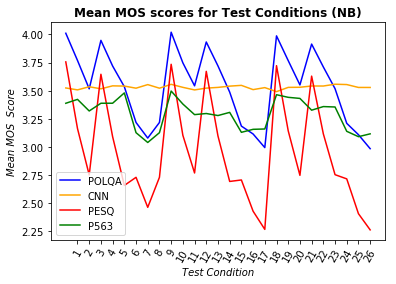

In [73]:

index = range(0,27)
opacity = 1.0
 
rects1 = plt.plot(index,'Mean_MOS_POLQA', data=dftcnb,
        alpha=opacity,
color='b',
label='POLQA')
 
rects2 = plt.plot(index, 'Mean_MOS_CNN', data=dftcnb,
alpha=opacity,
color='orange',
label='CNN')

rects3 = plt.plot( index, 'Mean_MOS_PESQ', data=dftcnb,
alpha=opacity,
color='red',
label='PESQ')

rects4 = plt.plot(index, 'Mean_MOS_P563', data=dftcnb,
alpha=opacity,
color='green',
label='P563')
 
plt.xlabel('Test Condition', style='italic')
plt.ylabel('Mean MOS  Score', style='italic')
plt.title('Mean MOS scores for Test Conditions (NB)', fontweight="bold")
plt.xticks(np.arange(1,27),rotation=60)
plt.yticks()
plt.legend()
plt.savefig("ModelPerfvsTestConditions.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')
plt.show()


In [75]:
dfopus=fullres2[fullres2['Degraded'].str.contains("opus")]
dfevs=fullres2[fullres2['Degraded'].str.contains("evs")]
dfplr5=fullres2[fullres2['Degraded'].str.contains("plr_5")]
dfplr3=fullres2[fullres2['Degraded'].str.contains("plr_3")]
dfplr1=fullres2[fullres2['Degraded'].str.contains("plr_1")]
dfdel50=fullres2[fullres2['Degraded'].str.contains("delay_50")]
dfdel100=fullres2[fullres2['Degraded'].str.contains("delay_100")]
dfdel300=fullres2[fullres2['Degraded'].str.contains("delay_300")]
dfjit10=fullres2[fullres2['Degraded'].str.contains("jitter_10")]
dfjit5=fullres2[fullres2['Degraded'].str.contains("jitter_5")]
dfjit1=fullres2[fullres2['Degraded'].str.contains("jitter_1")]
print(100-((np.mean(dfopus['CNNerr'])/np.mean(dfopus['MOS_polqa']))*100))
print(100-((np.mean(dfevs['CNNerr'])/np.mean(dfevs['MOS_polqa']))*100))
print('CNN EVS: '+str(np.mean(dfevs['MOS_CNN'])))
print('POLQA EVS: '+str(np.mean(dfevs['MOS_polqa'])))
print('CNN OPUS: '+str(np.mean(dfopus['MOS_CNN'])))
print('POLQA OPUS: '+str(np.mean(dfopus['MOS_polqa'])))
print('CNN PLR5: '+str(np.mean(dfplr5['MOS_CNN'])))
print('POLQA PLR5: '+str(np.mean(dfplr5['MOS_polqa'])))
print('CNN PLR3: '+str(np.mean(dfplr3['MOS_CNN'])))
print('POLQA PLR3: '+str(np.mean(dfplr3['MOS_polqa'])))
print('CNN PLR1: '+str(np.mean(dfplr1['MOS_CNN'])))
print('POLQA PLR1: '+str(np.mean(dfplr1['MOS_polqa'])))
print('CNN DEL50: '+str(np.mean(dfdel50['MOS_CNN'])))
print('POLQA DEL50: '+str(np.mean(dfdel50['MOS_polqa'])))
print('CNN DEL100: '+str(np.mean(dfdel100['MOS_CNN'])))
print('POLQA DEL100: '+str(np.mean(dfdel100['MOS_polqa'])))
print('CNN DEL300: '+str(np.mean(dfdel300['MOS_CNN'])))
print('POLQA DEL300: '+str(np.mean(dfdel300['MOS_polqa'])))
print('CNN JITTER10: '+str(np.mean(dfjit10['MOS_CNN'])))
print('POLQA JITTER10: '+str(np.mean(dfjit10['MOS_polqa'])))
print('CNN JITTER5: '+str(np.mean(dfjit5['MOS_CNN'])))
print('POLQA JITTER5: '+str(np.mean(dfjit5['MOS_polqa'])))
print('CNN JITTER1: '+str(np.mean(dfjit1['MOS_CNN'])))
print('POLQA JITTER1: '+str(np.mean(dfjit1['MOS_polqa'])))


#(dfopus[['MOS_CNN','MOS_polqa']].astype(float)).plot(kind='bar', subplots=False)


84.1575385217079
84.32456949888795
CNN EVS: 3.5319326
POLQA EVS: 3.488352272727272
CNN OPUS: 3.5312855
POLQA OPUS: 3.5674240532667496
CNN PLR5: 3.5335348
POLQA PLR5: 3.353661563922217
CNN PLR3: 3.5304291
POLQA PLR3: 3.5224124352331607
CNN PLR1: 3.530851
POLQA PLR1: 3.710086026017625
CNN DEL50: 3.5310545
POLQA DEL50: 3.530382605059586
CNN DEL100: 3.5298595
POLQA DEL100: 3.521334156886967
CNN DEL300: 3.5339398
POLQA DEL300: 3.5319895506792056
CNN JITTER10: 3.53398
POLQA JITTER10: 3.1025538525269263
CNN JITTER5: 3.5371444
POLQA JITTER5: 3.7182344428364686
CNN JITTER1: 3.528817
POLQA JITTER1: 3.43183249895703


In [54]:
dfopus.rename(columns={"MOS_polqa": "MOS_polqa_opus", "MOS_CNN": "MOS_CNN_opus"}, inplace=True)
dfevs.rename(columns={"MOS_polqa": "MOS_polqa_evs", "MOS_CNN": "MOS_CNN_evs"}, inplace=True)
opscr=dfopus[['MOS_polqa_opus','MOS_CNN_opus']]
evsscr=dfevs[['MOS_polqa_evs','MOS_CNN_evs']]
dfcodecs=pd.concat([evsscr,opscr], axis=1)
#dfcodecs.rename(columns({'MOS_polqa_evs':np.float32,'MOS_CNN_evs':np.float32,'MOS_polqa_opus':np.float32,'MOS_CNN_opus':np.float32})
#(dfcodecs[['MOS_polqa_opus','MOS_polqa_evs']].astype(float)).plot(kind='hi', subplots=True)
#dfcodecs

avgs={'Condition':['opus','evs','plr5','plr3','plr1','d50','d100','d300','j1','j5','j10'], 
      'Mean_MOS_POLQA':[dfcodecs["MOS_polqa_opus"].mean(),
                        dfcodecs["MOS_polqa_evs"].mean(), 
                        dfplr5['MOS_polqa'].mean(),
                        dfplr3['MOS_polqa'].mean(),
                        dfplr1['MOS_polqa'].mean(),
                        dfdel50['MOS_polqa'].mean(),
                        dfdel100['MOS_polqa'].mean(),
                        dfdel300['MOS_polqa'].mean(),
                        dfjit1['MOS_polqa'].mean(), 
                        dfjit5['MOS_polqa'].mean(),
                        dfjit10['MOS_polqa'].mean()],
     'Mean_MOS_CNN':[dfcodecs["MOS_CNN_opus"].mean(),
                        dfcodecs["MOS_CNN_evs"].mean(), 
                        dfplr5['MOS_CNN'].mean(),
                        dfplr3['MOS_CNN'].mean(),
                        dfplr1['MOS_CNN'].mean(),
                        dfdel50['MOS_CNN'].mean(),
                        dfdel100['MOS_CNN'].mean(),
                        dfdel300['MOS_CNN'].mean(),
                        dfjit1['MOS_CNN'].mean(), 
                        dfjit5['MOS_CNN'].mean(),
                        dfjit10['MOS_CNN'].mean()]}
dfavgs= pd.DataFrame(data=avgs)
print(dfcodecs["MOS_polqa_opus"].mean())
print(dfcodecs["MOS_polqa_evs"].mean())
dfavgs.to_csv('conditional_avgs.csv', index=False)
#,'plr5','plr3','plr1','d50','d100','d300','j1','j5','j10'

3.5674240532667496
3.4883522727272727


C:\Users\spike\Anaconda3\envs\tf_gpu2\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [55]:
dfavgs

,Condition,Mean_MOS_POLQA,Mean_MOS_CNN
0,opus,3.567424,3.531286
1,evs,3.488352,3.531933
2,plr5,3.353662,3.533535
3,plr3,3.522412,3.530429
4,plr1,3.710086,3.530851
5,d50,3.530383,3.531054
6,d100,3.521334,3.529860
7,d300,3.531990,3.533940
8,j1,3.431832,3.528817
9,j5,3.718234,3.537144


In [56]:

P563_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_P563'],'nb')
PESQ_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_PESQ'], 'nb')
CNN_mean_accnb=relacc(fullres2['MOS_polqa'],fullres2['MOS_CNN'], 'nb')

print(CNN_mean_accnb)
print(PESQ_mean_accnb)
print(P563_mean_accnb)

#print(np.mean(fullres2['PESQerr'])/np.mean(fullres2['MOS_polqa']))
#print(np.mean(fullres2['P563err'])/np.mean(fullres2['MOS_polqa']))
#print(np.mean(fullres2['CNNacc']))
#print(np.mean(fullres2['PESQacc']))
#print(np.mean(fullres2['P563acc']))
#print(np.sum(fullres2['P563acc'])/14425)
#print(100-(100*np.mean(fullres2['CNNrelerr'])))
#print(100-(100*np.mean(fullres2['PESQrelerr'])))
#print(100-(100*np.mean(fullres2['P563relerr'])))

91.93130354250775
90.69743629234893
86.09168470730849


In [191]:
fullres2.to_csv('comparedresultsNB.csv', index=False)
#fullres2=pd.read_csv('comparedresultsNB.csv', dtype={'Degraded':str, 'MOS_CNN':np.float32, 'MOS_polqa':np.float32, 'MOS_PESQ':np.float32, 'MOS_P563':np.float32, 'CNNerr':np.float32, 'PESQerr':np.float32, 'P563err':np.float32})

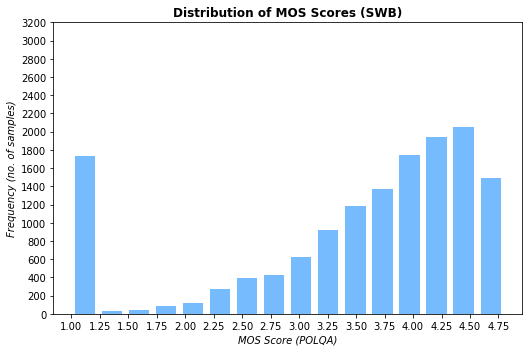

In [57]:
fig = plt.figure(figsize=(7.5,5))

x = fullres3['MOS_polqa'].astype(float)

# the histogram of the data
n, bins, patches = plt.hist(x, 16, alpha=1.0, rwidth=0.75,color='xkcd:sky blue',)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('MOS Score (POLQA)', style='italic')
plt.ylabel('Frequency (no. of samples)', style='italic')
plt.title('Distribution of MOS Scores (SWB)', fontweight="bold")
plt.xticks(np.arange(min(x), max(x), 0.25))
plt.yticks(np.arange(0,3300,200))
plt.grid(False)
plt.tight_layout()
plt.savefig("SWBhistPOLQA.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')
plt.show()

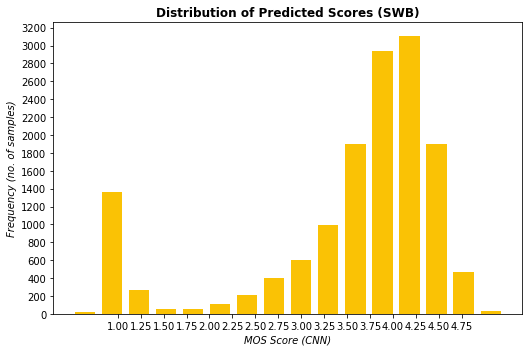

In [59]:
fig = plt.figure(figsize=(7.5,5))

x = fullres3['MOS_CNN'].astype(float)

# the histogram of the data
n, bins, patches = plt.hist(x, 16, alpha=1.0, rwidth=0.75, color='xkcd:goldenrod',)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('MOS Score (CNN)',style='italic')
plt.ylabel('Frequency (no. of samples)',style='italic')
plt.title('Distribution of Predicted Scores (SWB)', fontweight="bold")
plt.xticks(np.arange(1.0, 5.0, 0.25))
plt.yticks(np.arange(0,3300,200))
plt.grid(False)
plt.tight_layout()
plt.savefig("SWBhistCNN.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')


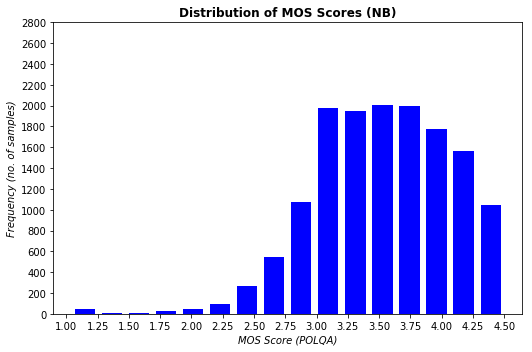

In [60]:
fig = plt.figure(figsize=(7.5,5))

x = fullres2['MOS_polqa'].astype(float)

# the histogram of the data
n, bins, patches = plt.hist(x, 16, alpha=1.0, rwidth=0.75, color='b')

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('MOS Score (POLQA)', style='italic')
plt.ylabel('Frequency (no. of samples)',style='italic')
plt.title('Distribution of MOS Scores (NB)',fontweight="bold")
plt.xticks(np.arange(1.0, 4.75, 0.25))
plt.yticks(np.arange(0,3000,200))
plt.grid(False)
plt.tight_layout()
plt.savefig("NBhistPOLQA.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')

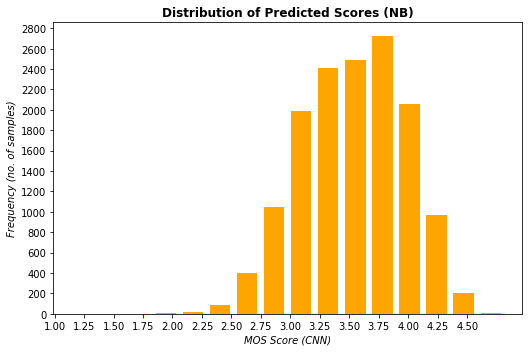

In [61]:
fig = plt.figure(figsize=(7.5,5))

x = fullres2['MOS_CNN'].astype(float)

# the histogram of the data
n, bins, patches = plt.hist(x, 16, alpha=1.0, rwidth=0.75, color='orange',)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('MOS Score (CNN)', style='italic')
plt.ylabel('Frequency (no. of samples)', style='italic')
plt.title('Distribution of Predicted Scores (NB)', fontweight="bold")
plt.xticks(np.arange(1.0, 4.75, 0.25))
plt.yticks(np.arange(0,3000,200))
plt.grid(False)
plt.tight_layout()
plt.savefig("NBhistCNN.png", dpi=180, pad_inches=0, bbox_inches='tight', transparent='False')

In [291]:
def relaccnb(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100-(np.mean((np.abs((y_true - y_pred) /(3.5 + y_true)))) * 100)

In [331]:
accswb={'Method':['CNN','PESQ', 'P563'], 
      'Relative Accuracy':[CNN_mean_accswb, PESQ_mean_accswb, P563_mean_accswb]}
dfaccswb= pd.DataFrame(data=accswb)
dfaccswb

,Method,Relative Accuracy
0,CNN,82.593253
1,PESQ,94.180886
2,P563,62.440366
